In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_data(K, n, mu, sigma):
    #generate vectors of means for each cluster from normal distibution
    mu_x = np.random.normal(mu, sigma, K)
    print("True means:", sorted(mu_x))
    
    #generate class assignments from categorical distribution
    c = np.random.multinomial(1, [1/K]*K, size=n)
    
    #generate data based on class assignments and each class' means
    X = np.random.normal(np.dot(c, mu_x), 1)
    
    #make pandas DF with data points and cluster number
    data = pd.DataFrame()
    data['x'] = X
    data['cluster'] = np.argmax(c, axis=1)
    return data

def plot_data(data, figsize=8):
    g = sns.FacetGrid(data, hue="cluster", palette="dark")
    g = (g.map(sns.distplot, 'x', hist=True, kde=False, norm_hist=True))
    ax = g.axes[0,0]
    ax.set_xlabel('n = %d'% n, fontsize=12)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    #facet.set(ylim=(-8, 8), xlim=(-8, 8))
    g.fig.set_figwidth(figsize)
    g.fig.set_figheight(figsize/2)
    plt.show()

In [3]:
class SVI(object):
    '''Univariate GMM with SVI'''
    def __init__(self, data, K=3, sigma=1, verbose=False):
        self.X = data.x
        self.cluster = data.cluster
        self.K = K
        self.N = self.X.shape[0]
        self.sigma = sigma
        self.sigma2 = sigma**2
        self.verbose = verbose

    def _initial(self):
        #assign equal initial probabilities to each cluster
        self.phi = np.full((self.N, self.K), 1/self.K)
        #draw random initial means for each cluster from standard normal distribution
        self.m = np.random.normal(0, self.sigma, self.K)
        #set std.dev of each cluster to 1
        self.s2 = np.ones(self.K)
        print('Initial means')
        print(self.m)
        #print('Initial std.dev')
        #print(self.s2)
        
    def _svi(self):
        # choose random data point from the dataset and update only its phi
        j = np.random.randint(self.N)
        e = np.outer(self.X[j], self.m) + (-0.5 * (self.m**2 + self.s2))[np.newaxis, :] #[np.newaxis, :] is to matrix
        self.phi[j] = np.exp(e) / np.sum(np.exp(e), axis=1)[:, np.newaxis] #normalization  K*N matrix
        #Compute coordinate update as though x_j were repeated n times
        m_grad = (self.X[j] - self.m) * self.phi[j] 
        #Update the global variational parameter with some learning rate
        lr = 0.001
        self.m = (1 - lr) * self.m + lr * m_grad

    def fit(self, max_iter=100, tol=0.001):
        start = time.time()
        self._initial()
        m_history = [self.m]
        s2_history = [self.s2]
                
        for iter_ in range(1, max_iter+1):
            self._svi()
            m_history.append(self.m)
            s2_history.append(self.s2)
            
            if (self.verbose) & (iter_ % 5 == 0):
                print(iter_, m_history[iter_])
            if np.linalg.norm(m_history[-1] - m_history[-2]) <= tol:
                print('SVI converged at iteration %d'%(iter_))
                break

        if iter_ == max_iter:
            print('SVI ended')
            
        print('Predicted means:', sorted(m_history[iter_]))
        end = time.time()
        print('Time elapsed:', end - start)
        self.plot_data()
        
    def plot_data(self, figsize=8):
        self.data = pd.DataFrame()
        self.data['x'] = self.X
        self.data['cluster'] = self.cluster
        g = sns.FacetGrid(self.data, hue="cluster", palette="dark")
        g = (g.map(sns.distplot, 'x', hist=True, kde=True, norm_hist=True))
        for i in range (self.K):
            sns.distplot(np.random.normal(self.m[i], 1, self.N), color='k', hist=False, kde=True)
            
        ax = g.axes[0,0]
        ax.set_xlabel('n = %d'% self.N, fontsize=12)
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        #facet.set(ylim=(-8, 8), xlim=(-8, 8))
        g.fig.set_figwidth(figsize)
        g.fig.set_figheight(figsize/2)
        plt.show()
        

In [4]:
K = 3

In [5]:
mu = 0 
sigma = 1

In [6]:
n = 1000

True means: [-1.9469703090225463, 0.09120471661981977, 1.0912827332721105]


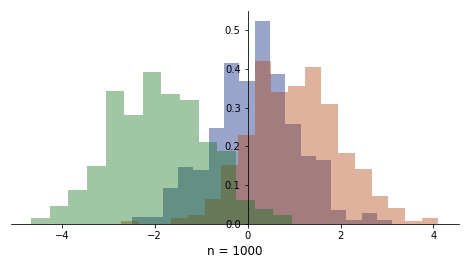

In [7]:
np.random.seed(8)
data = generate_data(K, n, mu, sigma)
plot_data(data)

Initial means
[ 0.20586487  1.16676171 -2.07263978]
SVI ended
Predicted means: [-1.8772065992105234, 0.1868716452411038, 1.0545832006630056]
Time elapsed: 0.021770954132080078


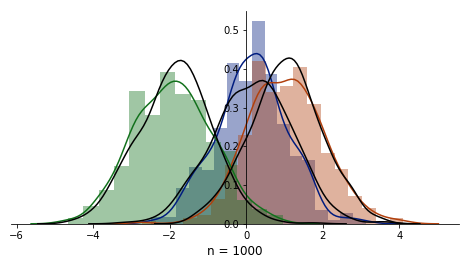

In [8]:
np.random.seed(53)
svi = SVI(data, K, sigma, verbose=False)
svi.fit()

True means: [-1.9469703090225463, 0.09120471661981977, 1.0912827332721105]
Initial means
[ 0.20586487  1.16676171 -2.07263978]
SVI ended
Predicted means: [-1.8767065362536632, 0.18672382015127573, 1.0524443181124474]
Time elapsed: 0.21790122985839844


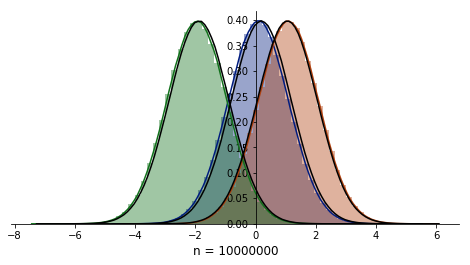

In [12]:
n = 10000000

np.random.seed(8)
data = generate_data(K, n, mu, sigma)

np.random.seed(53)
svi = SVI(data, K, sigma, verbose=False)
svi.fit()